# MLP
multilayer perceptron

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [154]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
  X, Y = [], []
  for w in words:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
    
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# We have 27 characters
# Let us cram it all into a 2D space
# 

# This is the lookup table
# each one of the 27 characters will have a 2D embedding
C = torch.randn((27, 2))

In [56]:
# Let's say we want the embedding of the 5th character
# It would be C[5]
# But why?
# Earlier we did
print(F.one_hot(torch.tensor(5), num_classes=27).float() @ C)
# and it's output is the same at C[5]
print(C[5])
# Which implies that we can just embedd the entire
# matrix X by getting the values of C for each value in X

tensor([-0.4924,  1.0145], grad_fn=<SqueezeBackward4>)
tensor([-0.4924,  1.0145], grad_fn=<SelectBackward0>)


In [57]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [58]:
# Hidden layer
# Our embedding is of the shape: torch.Size([32, 3, 2])
# So the number of inputs to this hidden layer would be 
# 3 x 2 (3 input neurons * 2D per neuron)
# The number of neurons in this layer, is a variable upto us
# Let's use 100 for the time being
W1 = torch.randn((6, 100))
b1 = torch.randn(100) # biases

In [59]:
# What we roughly want to do
# emb @ W1 + b1
# But this won't work since 
# emb is torch.Size([32, 3, 2])
# and W is 6 x 100
# So we somehow need to concat the emb into
# a shape that works ie. 32 x 6

emb[:, 0, :] # This gives the 32 x 2 embeddings of the first neuron
emb[:, 1, :] # This gives the 32 x 2 embeddings of the second neuron
emb[:, 2, :] # This gives the 32 x 2 embeddings of the third neuron
print(emb[:, 0, :].shape)


torch.Size([228146, 2])


In [60]:
# Now we concat these along dimension 1
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [12]:
# this is a cleaner way to do this
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [13]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [14]:
h

tensor([[-0.8648, -0.7958,  0.9699,  ...,  0.6826,  0.9913, -0.9458],
        [ 0.9392,  0.9527,  0.9970,  ...,  0.9770,  0.6407,  0.8702],
        [-0.9961,  0.8086,  0.7028,  ...,  0.8573,  0.9768,  0.9976],
        ...,
        [-0.8624, -0.9732,  0.6936,  ...,  0.7411,  0.9658, -0.7367],
        [ 0.7497, -0.8045, -0.9756,  ...,  0.6100,  0.9959,  0.0896],
        [ 0.9846,  0.5848,  0.7838,  ...,  0.9932,  0.9651,  0.8391]])

In [17]:
# Now we implement the output layer
# Input - 100
# Output - 27 (the possible characters that can come next)

W2 = torch.randn((100, 27))
b2 = torch.randn(27) 

In [18]:
logits = h @ W2 + b2

In [19]:
logits.shape

torch.Size([32, 27])

In [20]:
counts = logits.exp()

In [21]:
prob = counts / counts.sum(1, keepdim=True)

In [23]:
prob.shape

torch.Size([32, 27])

Final layer

so now we want to index into probs
and for each row, pluck out the prob assigned to the
correct character (which is givne using Y)

**NLL**

We want to get the log probability, and take it's avg and then negative

In [26]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.7613)

### So now, condensing it all into a more readable format

In [62]:
# dataset
X.shape, Y.shape 

(torch.Size([228146, 3]), torch.Size([228146]))

In [202]:
g = torch.Generator().manual_seed(2147483647) # our seed
C = torch.randn((27, 10), generator=g) # each one of the 27 characters will have a 2D embedding

# Hidden Layer
# The number of neurons in this layer, is a variable upto us
# Let's use 100 for the time being
W1 = torch.randn((30, 200), generator=g) # this layer receives 3 times 10 inputs
b1 = torch.randn(200, generator=g) # biases
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [203]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [204]:
for p in parameters:
  p.requires_grad = True

In [205]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# lrs

In [206]:
lri = []
lossi = []
stepi = []

In [207]:
iters = 2000000
for i in range(iters):
  # mini batch construct
  # will now only get 32 rows of X
  ix = torch.randint(0, Xtr.shape[0], (32, ))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32,100)
  logits = h @ W2 + b2 # (32, 27)
  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdim=True)
  # loss = -prob[torch.arange(32), Y].log().mean()

  # Inbuilt pytorch function to do the same
  # It's preferred because, pytorch will not create the intermediate tensors
  # and create efficient and clustered mathematical operations
  # It also makes the backward pass easier to implement
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # calculate the backward gradient

  # update the weights 
  lr = 0.1 if i < 1000000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
    
  # track metrics
  # lri.append(lre[i])
  lossi.append(loss.log10().item())
  stepi.append(i)
    
print(loss.item())

1.8777132034301758


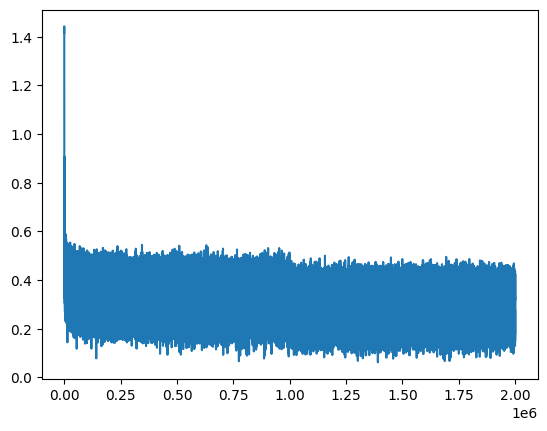

In [208]:
plt.plot(stepi, lossi)

In [209]:
# forward pass
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print(f"Test Loss {loss.item()}")

Test Loss 2.1268222332000732


In [210]:
# forward pass
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32,100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(f"Dev Loss {loss.item()}")

Dev Loss 2.121670961380005


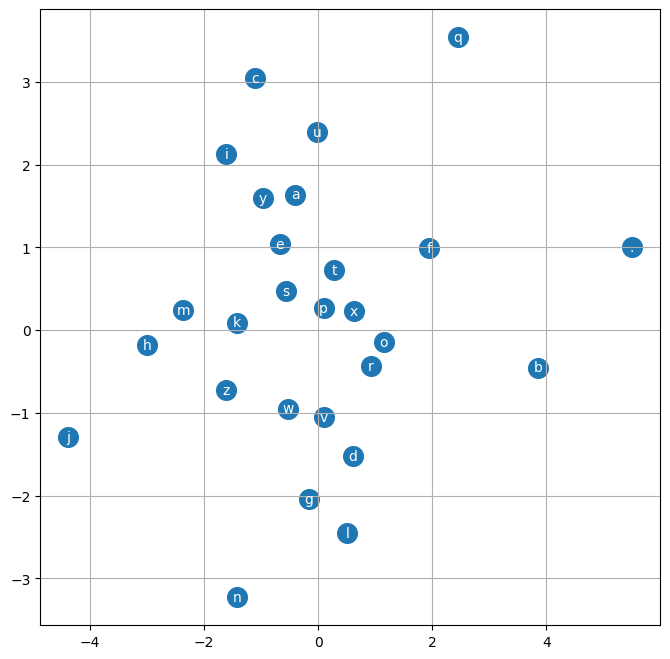

In [211]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

# Sampling from the model

In [212]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khy.
mili.
taty.
halaysie.
mahni.
farelyncia.
quil.
ramari.
chaiivia.
legend.
lucio.
miquint.
sulis.
alianni.
wavero.
dearisi.
jaxsinitraylen.
edi.
